In [1]:
import torch
from torch.nn.functional import mse_loss
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl

from model import vdm_model, networks
from utils import compute_pk
from data import constants

device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
plt.style.use(['science', 'vibrant'])
mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({
    'axes.titlesize': 11,
    'legend.loc': 'upper right',
    'legend.fontsize': 6
    })
colors = ['#4C4173', '#935083', '#D16580']

In [3]:
def load_model(dataset,
        cropsize = 256,
        gamma_min = -13.3,
        gamma_max = 13.3,
        embedding_dim = 48,
        norm_groups = 8,
        use_fourier_features = False,
        add_attention = True,
        noise_schedule = 'learned_linear',
        n_blocks = 4
):
    vdm = vdm_model.LightVDM(
            score_model=networks.UNetVDM(
                gamma_min=gamma_min,
                gamma_max=gamma_max,
                embedding_dim=embedding_dim,
                norm_groups=norm_groups,
                n_blocks=n_blocks,
                add_attention=add_attention,
                use_fourier_features=use_fourier_features
            ),
            dataset=dataset,
            gamma_min=gamma_min,
            gamma_max=gamma_max,
            image_shape=(1,cropsize,cropsize),
            noise_schedule=noise_schedule,
        )
    vdm = vdm.to(device=device)
    vdm = vdm.eval()
    
    ckpt = 'ckpt_path'

    state_dict=torch.load(ckpt)["state_dict"]
    vdm.load_state_dict(state_dict)
    return vdm.eval()

In [4]:
# Load data
datasets = [
            'IllustrisTNG', 
            'SIMBA', 
            'Astrid'
            ]
data = {}
normed_data = {}
for dataset in datasets:
    mass_mstar = np.load(f'Maps_Mstar_{dataset}_CV_z=0.00.npy')
    mass_cdm = np.load(f'Maps_Mcdm_{dataset}_CV_z=0.00.npy')
    mass_mstar = np.log10(mass_mstar+1)
    mass_cdm = np.log10(mass_cdm)
    data[dataset] = {
        'star': mass_mstar,
        'dm': mass_cdm
    }

    mean_input = constants.norms[dataset][0]
    std_input = constants.norms[dataset][1]
    mean_target = constants.norms[dataset][2]
    std_target = constants.norms[dataset][3]

    mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1).unsqueeze(1)
    mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1).unsqueeze(1)
    normed_data[dataset] = {
        'star': mass_mstar_normed,
        'dm': mass_cdm_normed
    }

In [5]:
sample_idx = 0

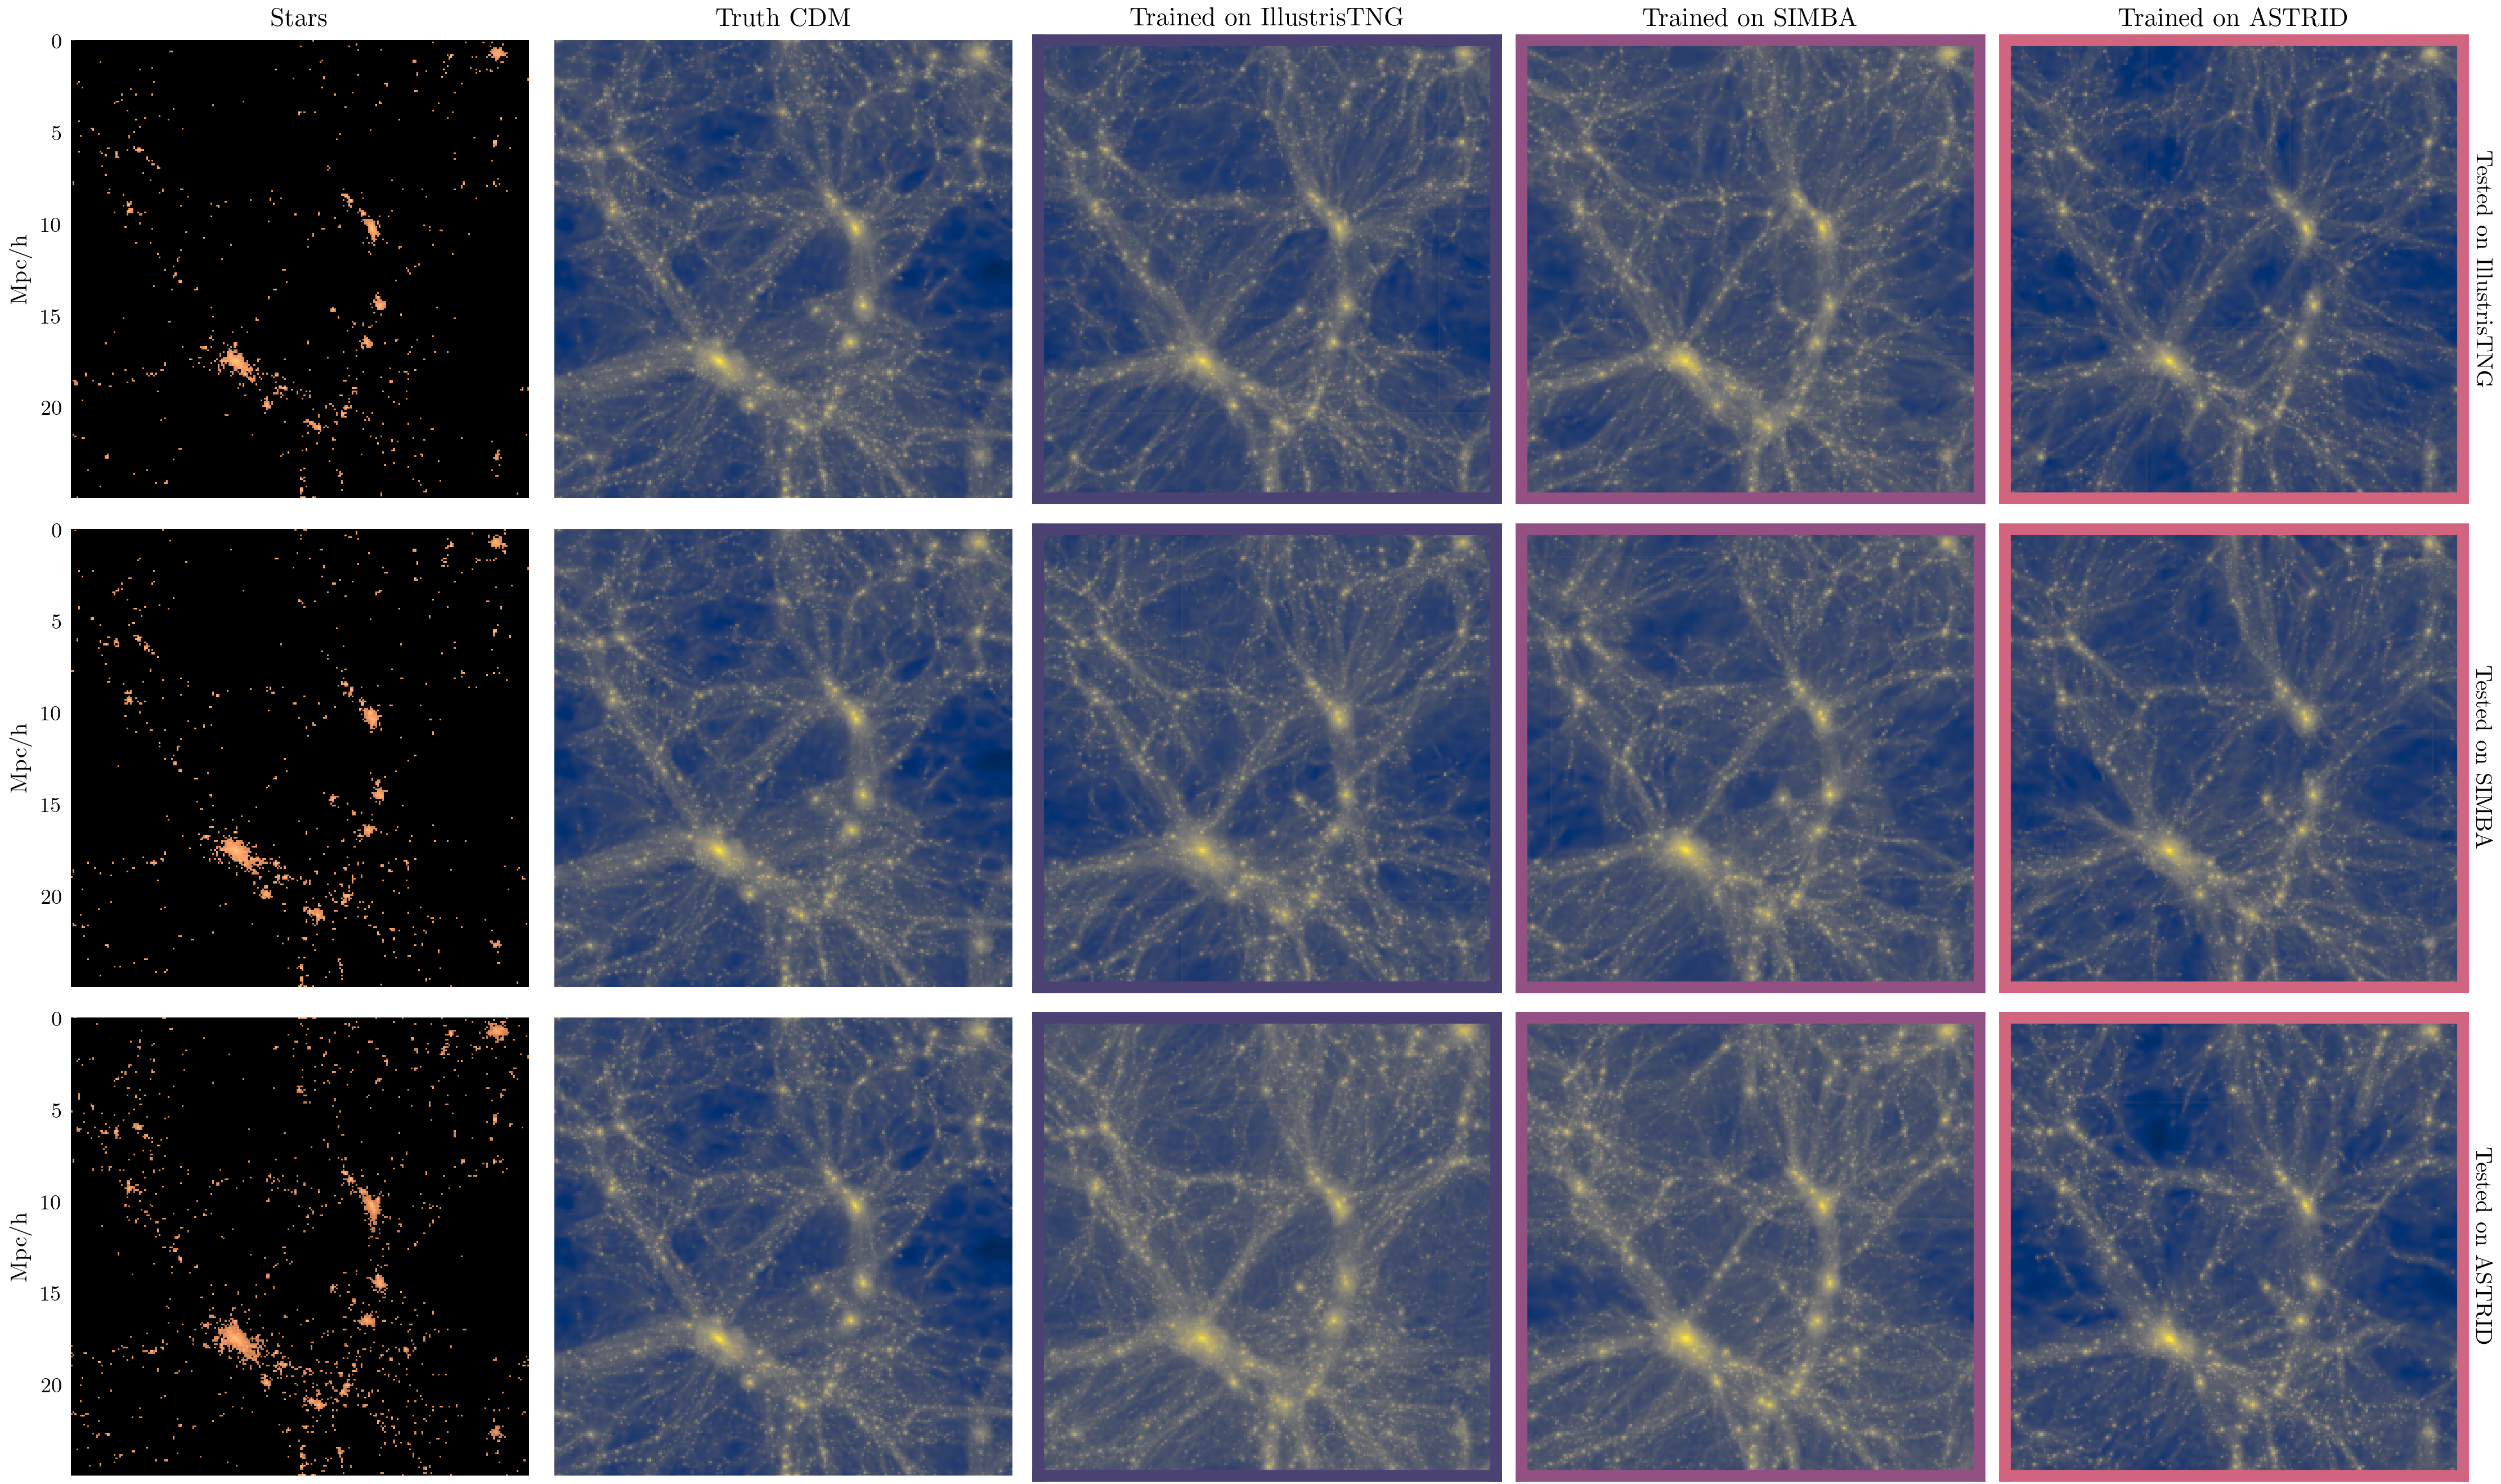

In [16]:
fig, axes = plt.subplots(3,5, figsize=(15,9))

for row, test in enumerate(datasets):
    axes[row,0].spines['top'].set_visible(False)
    axes[row,0].spines['left'].set_visible(False)
    axes[row,0].spines['bottom'].set_visible(False)
    axes[row,0].spines['right'].set_visible(False)
    axes[row,0].set_xticks([])
    axes[row,0].set_yticks([0., 51.2, 102.4, 153.6, 204.8, 256.], labels=["0", "5", "10", "15", "20", "25"])
    axes[row,0].set_ylabel("Mpc/h")
    axes[0,0].set_title("Stars")
    axes[row,0].imshow(data[test]['star'][sample_idx].squeeze(), cmap='copper', vmin=0, vmax=13)
    axes[row,1].imshow(data[test]['dm'][sample_idx].squeeze(), cmap='cividis',vmin=10,vmax=14.5)
    axes[row,1].axis('off')
    axes[0,1].set_title("Truth CDM")
    for i, train in enumerate(datasets):
        vdm = load_model(train)
        normed_star = torch.Tensor((data[test]['star'] - constants.norms[train][0]) / constants.norms[train][1]).unsqueeze(1).unsqueeze(1)[sample_idx]
        sample = vdm.draw_samples(
                        conditioning=normed_star.to(device),
                        batch_size=1,
                        n_sampling_steps=vdm.hparams.n_sampling_steps,
                    )
        mean_target = constants.norms[train][2]
        std_target = constants.norms[train][3]
        sample = sample * std_target + mean_target
        ax = axes[row,i+2]
        ax.imshow(sample.squeeze().cpu(), cmap='cividis', vmin=10, vmax=14.5)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.setp(ax.spines.values(), lw=5, color=colors[i]);
        if row == 0:
            if train == 'Astrid':
                ax.set_title(f"Trained on ASTRID")
            else:
                ax.set_title(f"Trained on {train}")
        if i == 2:
            if test == 'Astrid':
                ax.text(1.02, 0.5, f"Tested on ASTRID", transform=ax.transAxes, va='center', rotation=270.)
            else:
                ax.text(1.02, 0.5, f"Tested on {test}", transform=ax.transAxes, va='center', rotation=270.)

plt.tight_layout()

In [6]:
def generate_samples(vdm, conditioning, batch_size=10, n=10):

    star = conditioning[0]
    star_fields = star.expand(batch_size, star.shape[0], star.shape[1], star.shape[2])

    maps = [] # n tensors of shape ([batch_size, 1, img_shape, img_shape])
    # draw n samples with the same conditioning
    for _ in range(n):
        sample = vdm.draw_samples(
            conditioning=star_fields,
            batch_size=batch_size,
            n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
        maps.append(sample)
        
    return maps

In [ ]:
# Get power spectra and cross correlations
generated_pks = {}
cross_true_pks = {}
generated_samples = {}
for dataset in datasets:
    vdm = load_model(dataset)
    generated_pks[dataset] = {}
    cross_true_pks[dataset] = {}
    for test in datasets:
        normed_star = torch.Tensor((data[test]['star'] - constants.norms[dataset][0]) / constants.norms[dataset][1]).unsqueeze(1).unsqueeze(1)[sample_idx]
        generated_normed = torch.vstack(
            generate_samples(
                vdm,
                conditioning=normed_star.to(device), 
                batch_size=20, 
                n=5,
            )
        )
        mean_target = constants.norms[dataset][2]
        std_target = constants.norms[dataset][3]
        generated = generated_normed * std_target + mean_target
        if test == dataset:
            generated_samples[dataset] = generated
        generated_pk, cross_true_pk = [], []
        loss = 0
        for sample in generated:
            generated_pk.append(compute_pk(10**sample.cpu().numpy()[None])[1])
            loss += mse_loss(torch.Tensor(data[test]['dm'][sample_idx]), sample.cpu().squeeze())

            k, cross_true_sample = compute_pk(10**data[test]['dm'][sample_idx][None][None], 10**sample[None].cpu().numpy())
            cross_true_pk.append(cross_true_sample)

        generated_pks[dataset][test] = [torch.stack(generated_pk), loss / len(generated)]
        cross_true_pks[dataset][test] = torch.stack(cross_true_pk)

In [9]:
true_pks = {}
stars_pks = {}
for dataset in datasets:
    k, dm_pk = compute_pk(10**data[dataset]['dm'][sample_idx][None,None],)
    true_pks[dataset] = dm_pk
    k, star_pk = compute_pk(10**data[dataset]['star'][sample_idx][None,None]-1,)
    stars_pks[dataset] = star_pk

In [11]:
k_idx = np.unique(np.arange(len(k))[np.logspace(0,np.log10(len(k)),50).astype(int)])

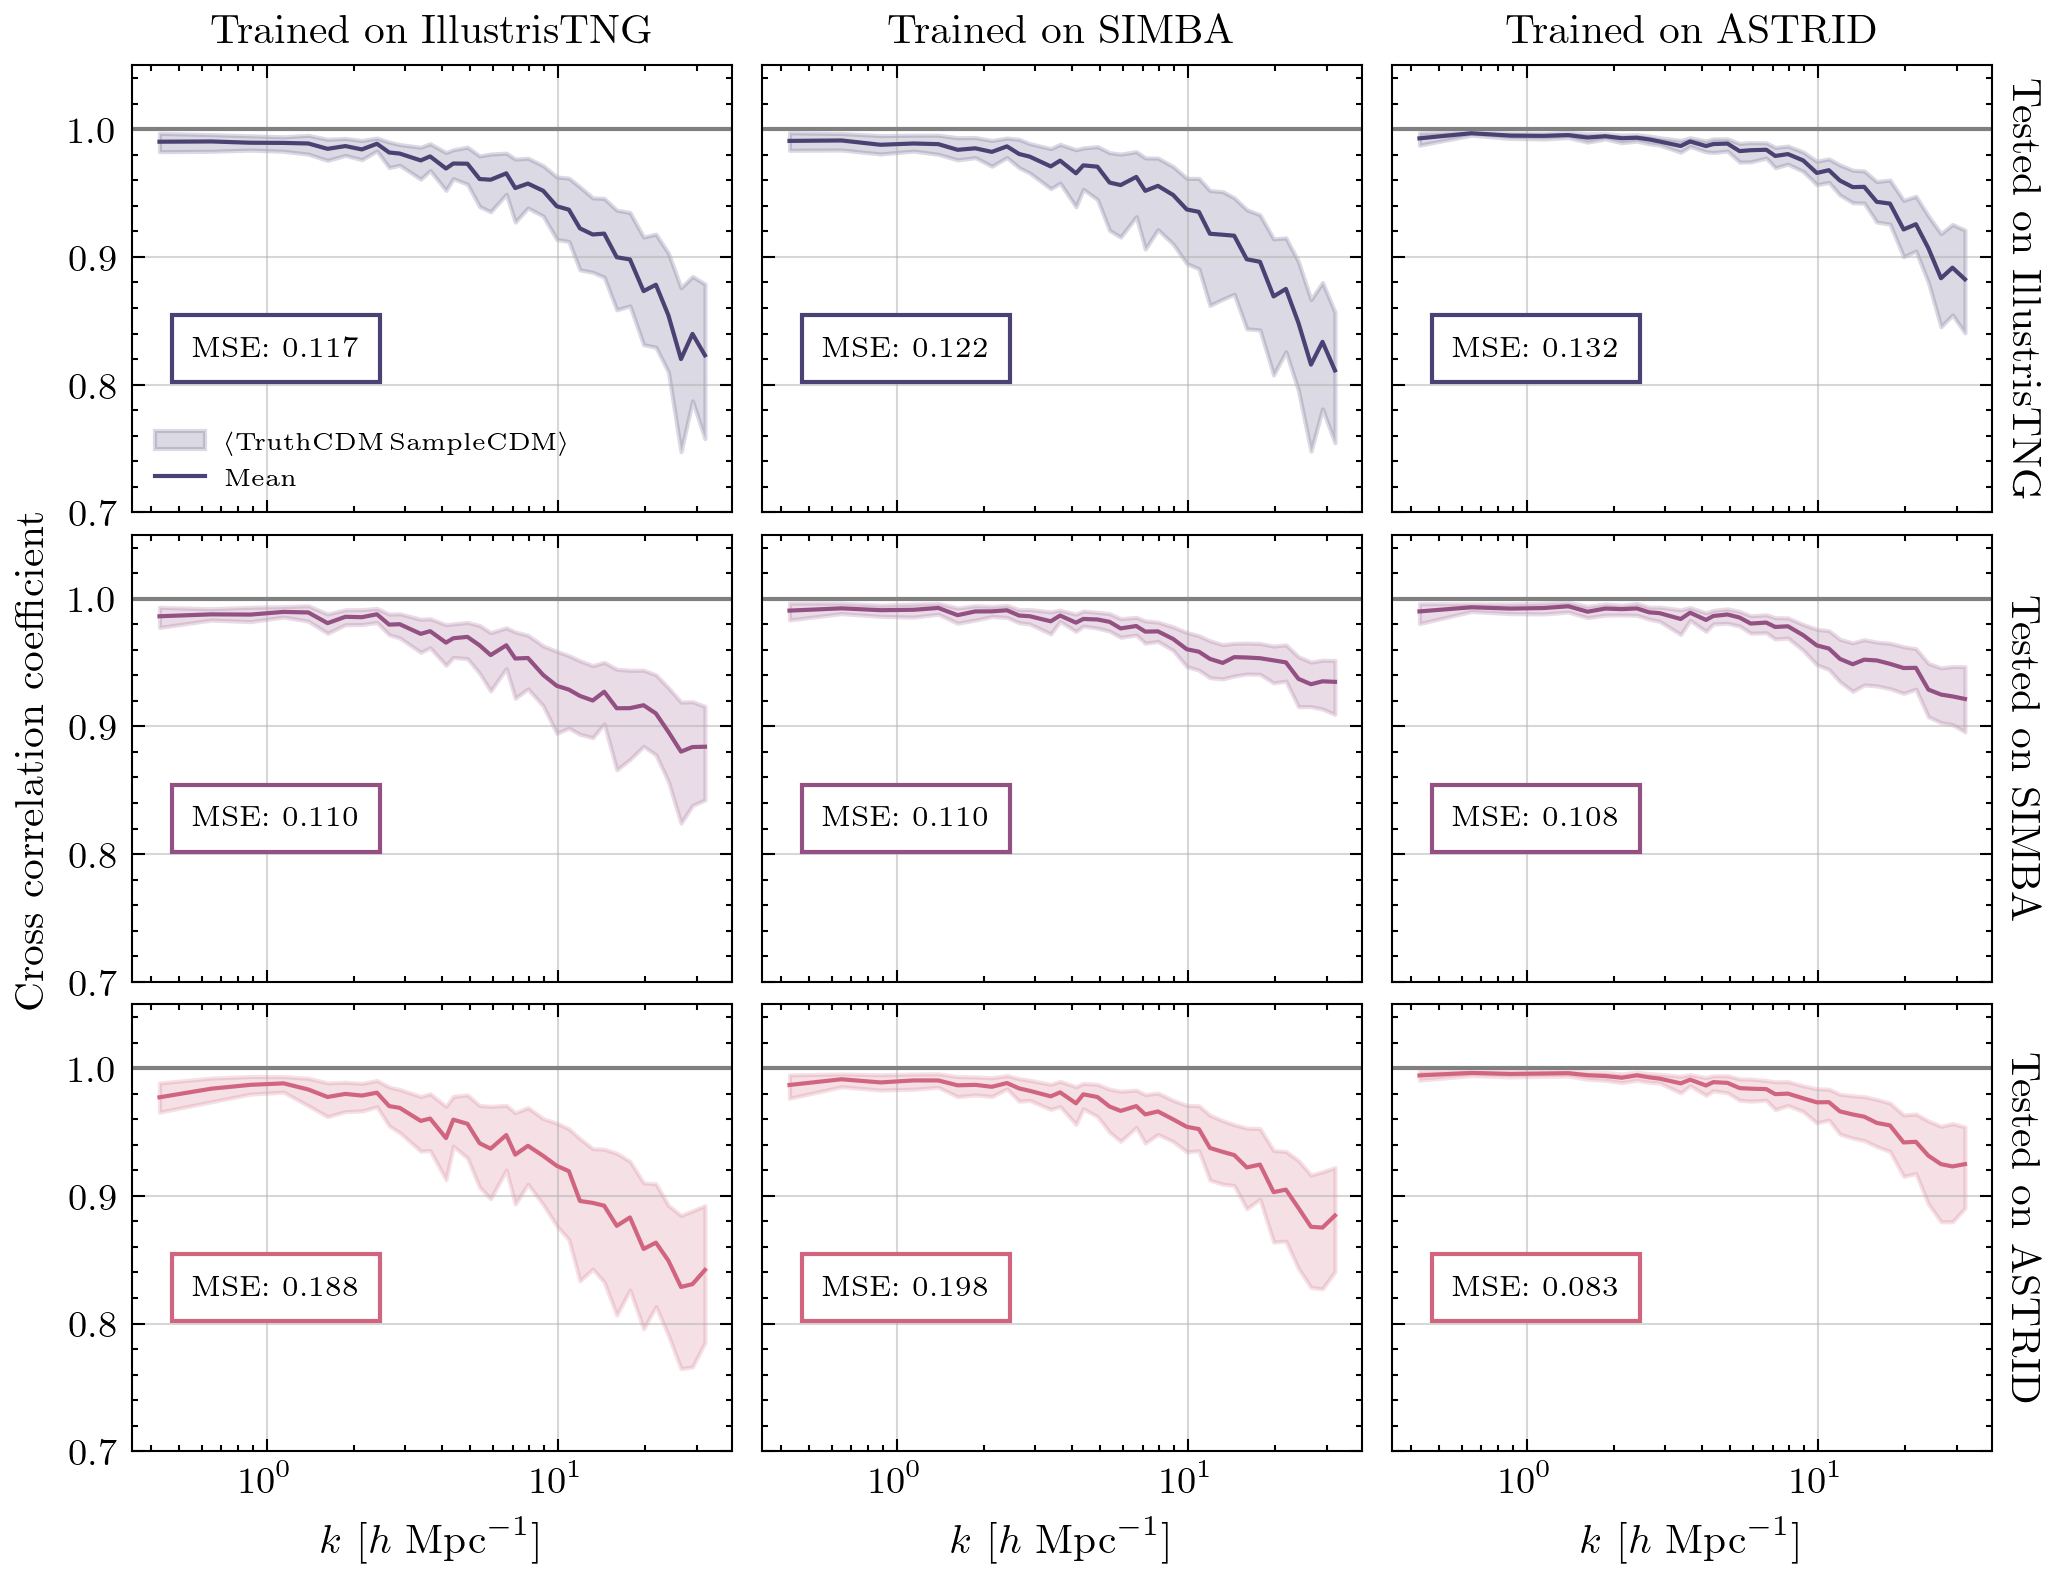

In [14]:
# Plot cross-dataset cross correlations
fig, axes = plt.subplots(3,3, figsize=(8,6), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for row, test in enumerate(datasets):
    if row == 1:
        axes[row,0].set_ylabel('Cross correlation coefficient')
    for col, train in enumerate(datasets):
        ax = axes[row,col]
        ax.grid(True, alpha=0.5,)

        coeffs = cross_true_pks[train][test][:, k_idx] / np.sqrt(true_pks[test][k_idx]) / np.sqrt(generated_pks[train][test][0][:, k_idx].cpu())

        ax.fill_between(
            k[k_idx],
            np.percentile(coeffs, 10, axis=0),
            np.percentile(coeffs, 90, axis=0),
            color=colors[row],
            alpha=0.2,
            label=r'$\langle \text{TruthCDM} \, \text{SampleCDM} \rangle$'
        )
        ax.semilogx(k[k_idx], coeffs.mean(axis=0), color=colors[row], label='Mean')
        ax.axhline(1.0, color='gray')
        ax.set_ylim(0.7,1.05)
        ax.text(0.1, 0.35, 'MSE: {:.3f}'.format(generated_pks[train][test][1].item()), transform=ax.transAxes, fontsize=7, bbox={'facecolor': 'white', 'edgecolor': colors[row], 'pad': 5})

        if row == col == 0:
            ax.legend(loc='lower left')
        if row == 2:
            ax.set_xlabel('$k$ [$h \ \mathrm{Mpc}^{-1}$]')
        if row == 0:
            if train == 'Astrid':
                ax.text(0.5, 1.05, f"Trained on ASTRID", transform=ax.transAxes, ha='center')
            else:
                ax.text(0.5, 1.05, f"Trained on {train}", transform=ax.transAxes, ha='center')
        if col == 2:
            if test == 'Astrid':
                ax.text(1.02, 0.5, f"Tested on ASTRID", transform=ax.transAxes, va='center', rotation=270.)
            else:
                ax.text(1.02, 0.5, f"Tested on {test}", transform=ax.transAxes, va='center', rotation=270.)
